# Jupyter notebook RT2 Assignment: ROS Mobile Robots Simulator 
------------
Developer: Thomas Campagnolo (S5343274)

Course: Research Track 2 (A.Y. 2021-22)

MSc Robotics Engineering, University of Genoa.

The notebook consists in interact with the simulation of the third assignment of the Research Track 1 course, which is able to:
* switch to different modalities, and manage them;
* plot the robot position (x- and y- coordinates), the laser scanner data, in particular the shape of the environment and the status of the reached and unreached targets.


## Overview
    
The aim is to replace the old user interface, implemented in the command line terminal, using functions and widgets to give a more user friendly interface.

The functionalities that the code must guarantee are:
* buttons for handling the different modalities:
    - autonomous driving mode
    - manual driving mode (with the possibility of activate/deactivate collision avoidance)
    - reset robot position
    - reset GUI
    - close the program and kill all ros nodes.
* plot the robot position and laser scan;
* plot the status of the number of reached and unreached targets.

## How to run

To run the program is essential to clone the whole directory, switch to the branch ```rt2_assignments``` and run the ROS simulation before launching the Jupyter notebook.

To launch the simulation, it is sufficient to type the following command in the terminal:

```roslaunch final_assignment rt2_assignment.launch```

Once launched, be careful to control that the move_base package is running correctly, since it could happen that it won't work sometimes. If this happens, stop the simulation and launch it again.

It is now time to run the Jupyter notebook. To run it I recommend using the ```Restart & Run All``` command placed in the *Kernel* menu since the notebook's cells should be run in order.

# Libraries

Let's start the notebook by import all the libraries and define all the messages and services which are going to be needed in the project.

In [1]:
# Libraries

%matplotlib widget

import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt

import rospy
import time
import os
import tf
import sys
import actionlib
import numpy as np

from IPython.display import clear_output
from IPython.display import display
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
from ipywidgets import interact, interactive
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from tf.transformations import quaternion_matrix


# Messages
from std_msgs.msg import String
from geometry_msgs.msg import Twist, Vector3
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from std_msgs.msg import Int32

# Services
from final_assignment.srv import GoalCoordinates
from std_srvs.srv import Empty

# Initialize ROS node

The ```rospy.init_node``` function initializes the ROS node.


In [2]:
rospy.init_node('user_interface_controller')

# User Interface Components

The following cells define the components useful for defining the graphic user interface (GUI).

In this part we define the buttons that are going to be used by the user to decide the driving modalities, previously listed.

In [3]:
b1 = Button(description = 'Autonomus Driving Experience',
           layout = Layout(width = 'auto', align = "center", grid_area = 'b1'),
           style = ButtonStyle(button_color = 'lightblue'))

b2 = Button(description = 'Manual Driving Experience',
           layout = Layout(width = 'auto', grid_area = 'b2'),
           style = ButtonStyle(button_color = 'lightblue'))

b3 = Button(description = 'Reset Robot Position',
            layout = Layout(width = 'auto', grid_area = 'b3'),
            style = ButtonStyle(button_color = 'lightblue'))

b4 = Button(description = 'Close program',
            layout = Layout(width = 'auto', grid_area = 'b4'),
            button_style='danger')

b5 = Button(description = 'Reset GUI',
            layout = Layout(width = 'auto', grid_area = 'b5'),
            button_style='warning')

## Autonomous Driving Interface Widgets

Definition of widgets displayed only in Autonomous Driving Experience mode.

In [4]:
# text boxes for entering the x- and y- coordinate of the target to reach
x_goal = widgets.FloatText(
                    value=-2.5,
                    description='x: ',
                    disabled=False
)

y_goal = widgets.FloatText(
                    value=6.0,
                    description='y: ',
                    disabled=False
)

# Start button and cancel button to start the simulation and to go back to the main GUI respectively.
bstart = widgets.Button(description="Start")
bcanc  = widgets.Button(description="Back to Main GUI")


## Manual Driving Interface Widgets

Definition of widgets displayed only in Manual Driving Experience mode.

In [5]:
# slider used for change the linear and the angular velocity of the robot
slider_velocity = widgets.FloatSlider(value=1,
                                   min=0, 
                                   max=3, 
                                   step=0.1, 
                                   description='Robot velocity: ',
                                   disabled=False,
                                   orientation='horizontal')

# joystic console for manual control of the robot
b_up = Button(description = 'UP',
              layout = Layout(grid_area = 'b_UP'))

b_left = Button(description = 'LEFT',
                layout = Layout(grid_area = 'b_LEFT'))

b_stop = Button(description = 'STOP',
                layout = Layout(grid_area = 'b_STOP'))

b_right = Button(description = 'RIGHT',
            layout = Layout(grid_area = 'b_RIGHT'))

b_down = Button(description = 'DOWN',
                layout = Layout(grid_area = 'b_DOWN'))


man_drive_key = GridBox(children=[b_up, b_left, b_stop, b_right, b_down],
                        layout=Layout(width='50%', grid_template_rows='auto auto',
                        grid_template_columns='33% 33% 33% 33%',
                        grid_template_areas='''
                                            " . b_UP . "
                                            "b_LEFT b_STOP b_RIGHT "
                                            " . b_DOWN . "
                                            ''')
)

# checkbox for activate/deactivate the collision avoidance option during the manual navigation mode
assistance = widgets.Checkbox(value=False,
                               description='Assisted manual experience, collision avoidance',
                               disabled=False,
                               indent=False
)

# Robot Behavior

Here the robot assumes the correct behavior according to the user choice.


In [6]:
# set the velocities according to the slider value (used only in manual driving mode)
def set_velocity(direction):
    
    vel_msg = Twist()
    
    if direction =='go_ahead':  # the robot go forward with slider_velocity value (linear velocity)
        vel_msg.linear.x = slider_velocity.value
    
    elif direction == 'go_back': # the robot go back with slider_velocity value (linear velocity)
        vel_msg.linear.x = -slider_velocity.value
    
    elif direction == 'turn_left': # the robot turn on the left with slider_velocity value (angular velocity)
        vel_msg.angular.z = slider_velocity.value
    
    elif direction == 'turn_right': # the robot turn on the right with slider_velocity value (angular velocity)
        vel_msg.angular.z = -slider_velocity.value
        
    elif direction == 'stop':  # the robot will not move
        vel_msg.linear.x = 0
        vel_msg.angular.z = 0
    
    # initialize the publisher to public the velocities on topic cmd_vel 
    pub_vel = rospy.Publisher('cmd_vel',Twist, queue_size=100)
    pub_vel.publish(vel_msg)

In [7]:
# menage all the different joystic buttons and call the function to set the velocity 
def go_ahead(b):
    set_velocity('go_ahead')
def go_back(b):
    set_velocity('go_back')
def turn_left(b):
    set_velocity('turn_left')
def turn_right(b):
    set_velocity('turn_right')
def stop_move(b):
    set_velocity('stop')
    
# interface console to drive the robot with buttons in manual driving experience
def driving_console():
    display(man_drive_key) # joystic console
    display(assistance) # checkbox assistance
    display(bcanc) # back to main GUI

    # listener for buttons click and assistance check
    b_up.on_click(go_ahead)
    b_down.on_click(go_back)
    b_left.on_click(turn_left)
    b_right.on_click(turn_right)
    b_stop.on_click(stop_move)
   
    assistance.observe(assistance_handler, names='value')
    bcanc.on_click(on_button_clicked_canc)

In [8]:
# callback functions for the events

# back to main GUI button
def on_button_clicked_canc(b):
    clear_output()

# set the value of the ROS parameter for collision avoidance control in assistedDriving node
def assistance_handler(b):
    rospy.set_param("/collision_avoidance", assistance.value)
    
# service to set the new target position (x- y- coordinates) when start button is click    
def on_button_clicked_start(b):
    with output:
        rospy.wait_for_service('goal_coordinates')
        new_pose = rospy.ServiceProxy('goal_coordinates', GoalCoordinates)
        pose = new_pose(x_goal.value , y_goal.value)
        if pose.return_ == 1:
            goal_status = Int32()
            print("Goal position reached!")
            # publish the goal status to the data message for the analylis plot (goal reached)
            pub_status = rospy.Publisher('/goal_status', Int32, queue_size = 100)
            goal_status.data = 1
            pub_status.publish(goal_status)
        else:
            print("Time out. Goal Position not reached!")
            # publish the goal status to the data message for the analylis plot (goal unreached)
            pub_status = rospy.Publisher('/goal_status', Int32, queue_size = 100)
            goal_status.data = 0
            pub_status.publish(goal_status)

In [9]:
# handler for autonomous driving mode
def autonomous_drive(b):
    display(x_goal, y_goal, bstart, bcanc)
    bstart.on_click(on_button_clicked_start)
    bcanc.on_click(on_button_clicked_canc)

# handler for manual driving mode
def manual_drive(b):
    display(slider_velocity)
    driving_console()

# handler for reset the robot position
def reset_robot_position(b):
    global reset_world
    # Create a client to reset the simulation environment
    rospy.wait_for_service('/gazebo/reset_world')
    reset_world = rospy.ServiceProxy('/gazebo/reset_world', Empty)
    reset_world()
    print("Robot's position has been resetted, wait a second...")
    time.sleep(3)
    clear_output()

# handler for close the program and kill all the ROS nodes
def close_all(b):
    nodes = os.popen("rosnode list").readlines()
    for i in range(len(nodes)):
        nodes[i] = nodes[i].replace("\n","")
    for node in nodes:
        os.system("rosnode kill "+ node)
    os.system("killall -9 rosmaster")
    clear_output()

# handler for reset the GUI
def reset_gui(b):
    print("Reset GUI, wait a second...")
    time.sleep(3)
    clear_output()
    

# listener for driving choice
b1.on_click(autonomous_drive)
b2.on_click(manual_drive)
b3.on_click(reset_robot_position)
b4.on_click(close_all)
b5.on_click(reset_gui)

# Display UI

Main user interface display.

**Every time you want to change the mode (autonomous and manual), you need to reset the interface with the appropriate ```Reset GUI``` button and then run the cell again (this for better display quality)**.

In [14]:
print('Assignment 3: ROS Mobile Robots Simulator! \n')
print('Hello! Please select between the different modalities to decide the robot driving mode: ')

main_gui = GridBox(children = [b1, b2, b3, b4, b5],
                layout = Layout(
                           width = '100%',
                           grid_template_rows = 'auto auto auto',
                           grid_template_columns = '33% 33% 33%',
                           grid_template_areas = '''
                                                "b1 b2 b3"
                                                ". b5 b4"
                                                 ''')
)


#create an output cell
output = widgets.Output()

#display both button and output cell display main menu of the GUI
display(main_gui, output)

Assignment 3: ROS Mobile Robots Simulator! 

Hello! Please select between the different modalities to decide the robot driving mode: 


GridBox(children=(Button(description='Autonomus Driving Experience', layout=Layout(grid_area='b1', width='auto…

Output()

FloatText(value=-2.0, description='x: ')

FloatText(value=8.0, description='y: ')

Button(description='Start', style=ButtonStyle())

Button(description='Back to Main GUI', style=ButtonStyle())

# Data Visualizer 

The class ```Visualiser``` is done for visualise some data. In this implementation we plot:
* Robot Odometry (position in x-, y- coordinate) in the environment (topic ```/odom```);
* Shape of the environment (or obstacle) detected with the laser scanner of the robot (topic ```/scan```).

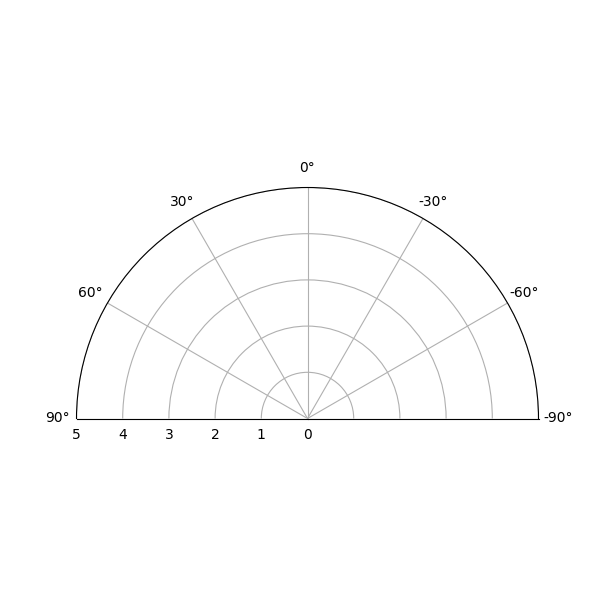

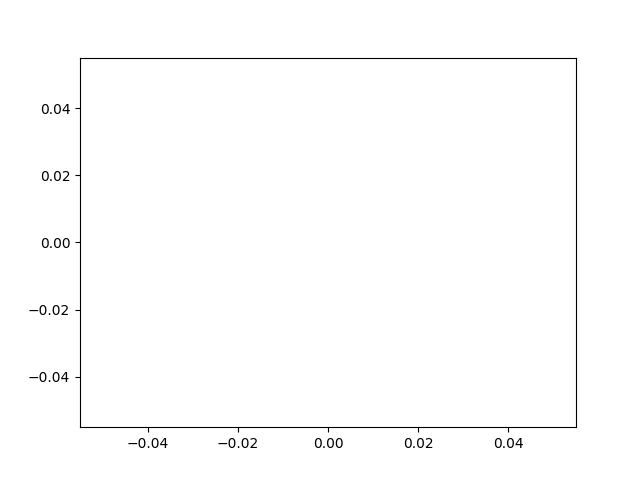

In [11]:
laser_ang = []

class Visualiser:
    def __init__(self):
        # Subplot for Odometry visualiser
        self.figure_odom, self.ax_odom = plt.subplots()
        self.ln_odom, = self.ax_odom.plot([], [], 'bo')
        self.x_data, self.y_data = [], []
        
        # Subplot for Laser Scanner visualiser
        self.figure_laser = plt.figure(figsize = (6, 6))
        self.ax_laser = plt.subplot(111, polar = True)
        plt.grid(True)
        self.ax_laser.set_thetalim(np.pi/2, -np.pi/2)
        self.ax_laser.set_rmax(5)
        self.ax_laser.set_theta_zero_location("N")
        self.ln_laser, = self.ax_laser.plot([], [], 'r-')
        self.laser_dist = []
        
    def plot_init(self):
        # Initialization odometry plot
        self.ax_odom.set_title("Robot Odometry", fontsize = 16, fontweight = 'bold')
        self.ax_odom.set_xlabel("x [m]", fontsize = 10, fontweight = "bold")
        self.ax_odom.set_ylabel("y [m]", fontsize = 10, fontweight = "bold")
        self.ax_odom.set_xlim(-10, 10)
        self.ax_odom.set_ylim(-10, 10)
        
        # Initialization laser scan plot
        self.ax_laser.set_title("Laser Scanner Data", fontsize = 16, fontweight = "bold")
        self.ax_laser.set_xlabel("Distance", fontsize = 10, fontweight = "bold")
        return self.ln_odom, self.ln_laser

    # Callback function for robot's odometry subscriber
    def odom_callback(self, msg):
        self.x_data.append(msg.pose.pose.position.x)
        self.y_data.append(msg.pose.pose.position.y) 
       
    # Callback function for robot's laser scan subscriber
    def laser_callback(self, msg):
        global laser_ang
        self.laser_dist = msg.ranges
        laser_ang = np.arange(msg.angle_min, msg.angle_max+msg.angle_increment, msg.angle_increment)
                
   # Function for robot's odometry plot update
    def update_plot_odom(self, frame):
        self.ln_odom.set_data(self.x_data, self.y_data)
        return self.ln_odom
    
     # Function for robot's laser scan plot update
    def update_plot_laser(self, frame):
        global laser_ang
        self.ax_laser.set_rmax(5)
        self.ln_laser.set_data(laser_ang, self.laser_dist)
        return self.ln_laser
    
    
visualiser = Visualiser()

# Subscriber and animation for plotting the robot position continuously updating
sub_odom = rospy.Subscriber('/odom', Odometry, visualiser.odom_callback)
ani_odom = FuncAnimation(visualiser.figure_odom, visualiser.update_plot_odom, init_func=visualiser.plot_init)

# Subscriber and animation for plotting the robot laser scanner data continuously updating
sub_laser = rospy.Subscriber('/scan', LaserScan, visualiser.laser_callback)
ani_laser = FuncAnimation(visualiser.figure_laser, visualiser.update_plot_laser, init_func = visualiser.plot_init)

plt.show(block=True)

# Analysis

In this cell, with the ```Analysis``` class, we analyze the efficiency of the code in autonomous navigation mode according to a bar plot. In particular, after sending goal coordinates and receiving status feedback, we plot *Goal Reached* (green bar) and *Unreached* (red bar) values for better visualization and analysis.

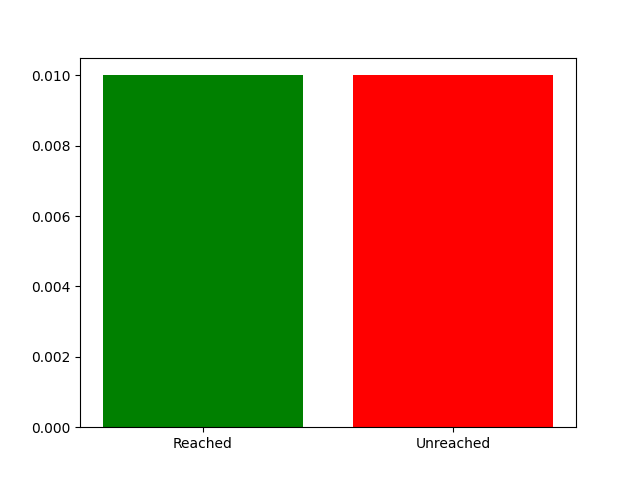

In [12]:
class Analysis:
    def __init__(self):
        self.figure_analysis, self.ax_analysis = plt.subplots()
        self.y_data = [0.01,0.01] 
        self.ln_analysis = plt.bar(['Reached', 'Unreached'], self.y_data, color = ['green', 'red'])
        
    def plot_init(self):
        # Initializes the goal status reached/unreached plot 
        self.ax_analysis.set_title("Goal status: reached / unreached", fontsize = 16, fontweight = "bold")
        # self.ax_analysis.set_xlabel("Goal status", fontsize = 10, fontweight = "bold")
        self.ax_analysis.set_ylabel("Number of goal sets", fontsize = 10, fontweight = "bold")
        self.ax_analysis.set_ylim(0, 10)
        self.ax_analysis.set_yticks(np.arange(0, 10, 1))
        return self.ln_analysis
    
    def goal_status_callback(self, msg):
        if msg.data == 1:
            self.y_data[0]+=1
        elif msg.data == 0:
            self.y_data[1]+=1
            
    def update_plot(self, frame):
        self.ln_analysis = plt.bar(['Reached', 'Unreached'], self.y_data, color = ['green', 'red'])
        return self.ln_analysis

        
analysis = Analysis()

# Subscriber and animation for plotting the goal status continuously updating
sub_status = rospy.Subscriber('/goal_status', Int32, analysis.goal_status_callback)
ani_status = FuncAnimation(analysis.figure_analysis, analysis.update_plot, init_func = analysis.plot_init)
plt.show(block=True)